In [ ]:
#Bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

In [ ]:
#Tomar la dirección URL del archivo
url= 'https://raw.githubusercontent.com/Galm12/FisicaComputacional1/main/Actividad%20I/Datos.txt'
# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

#Copia de respaldo
df_work0 = df_dist.copy()

#Cambiar los valores "Nulo" por un campo vacio
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

#Convertir los valores de las distintas variables a números flotantes flotantes 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

#Creacion dataframe en caso de regresarse
df_work2 = df_work1.copy()

#Cambio de formato para la columna Fecha a un formato de fecha que comprende Python
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()

#Función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')

#Creasion de nuestro punto de partida
df_meteo = df_work2.copy()

#Copia del último DataFrame df_meteo y crea un DataFrame df_meteo_ts
df_meteo_ts = df_meteo.copy()

#Reemplazo el índice por la variable 'Fecha' 
df_meteo_ts = df_meteo_ts.set_index('Fecha')


In [ ]:
def test_stationarity(df_ts): 

#Determinar la Estadística de promedios móviles
  rolmean = df_ts.rolling(window=365, center=True).mean()
  rolstd = df_ts.rolling(window=365, center=True).std()

# Define el tamaño de la figura
  plt.rcParams["figure.figsize"] = (12,6)

#Graficar la Estadística de promedios móviles

  plt.plot(df_ts, color='blue',label='Original')
  plt.plot(rolmean, color='red', label='Rolling Mean')
  plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
  plt.legend(loc='best')
  plt.title('Promedio Móvil y Desviación Estándar')
  plt.grid()
  plt.show()

#Realiza la Prueba Aumentada de Dickey-Fuller:
  print('Resultados de la Prueba de Dickey-Fuller:')
  dftest = adfuller(df_ts, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4],
    index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

Text(0.5, 1.0, 'Inventario de Datos 1988-2016, Vicam SON')

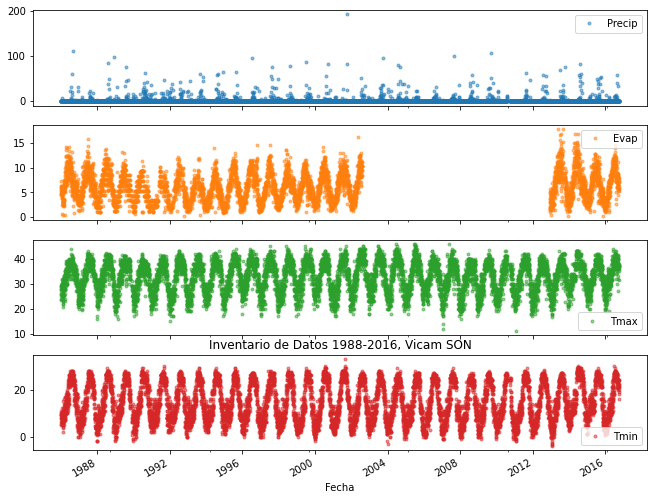

In [ ]:
#Visualización la colección del intervalo de 28 años para ver si hay datos faltantes
cols_plot = ['Precip', 'Evap', 'Tmax', 'Tmin']
ax_ylabels = ['Precip (mm)', 'Evap (mm)', 'Tmax °C', 'Tmin (°C)']
axes = df_meteo_ts[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', 
  figsize=(11, 9), subplots=True)
plt.title('Inventario de Datos 1988-2016, Vicam SON')

Al ver el grafico, se centrara en los tados de 1994 y 1999


In [ ]:
# Creamos la primer serie de Tiempo para analizar, 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información

start, end = '1994-01', '1999-12'
ts_P = df_meteo_ts[start:end].copy()

Text(0.5, 1.0, 'Inventario de Datos 1994-1999, Vicam SON')

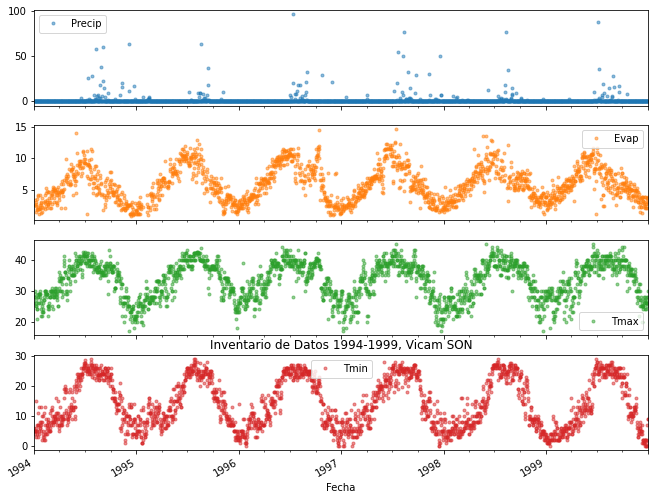

In [ ]:
#Visualización la colección del intervalo de 30 años para ver si hay datos faltantes
cols_plot = ['Precip', 'Evap', 'Tmax', 'Tmin']
ax_ylabels = ['Precip (mm)', 'Evap (mm)', 'Tmax °C', 'Tmin (°C)']
axes = ts_P[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', 
  figsize=(11, 9), subplots=True)
plt.title('Inventario de Datos 1994-1999, Vicam SON')

In [ ]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico

ts_TMtest = ts_P ['Tmax'].copy()
ts_Tmitest = ts_P ['Tmin'].copy()

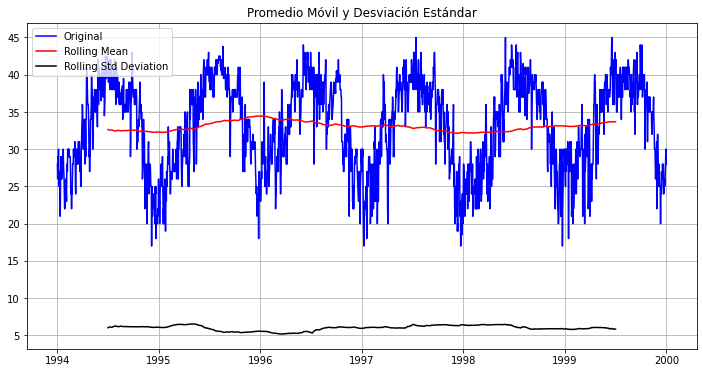

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.422676
p-value                           0.010210
#Lags Used                       13.000000
Number of Observations Used    2177.000000
Critical Value (1%)              -3.433357
Critical Value (5%)              -2.862869
Critical Value (10%)             -2.567477
dtype: float64


In [ ]:
test_stationarity(ts_TMtest)


como podemos ver el p-value es mucho mayor a 0.05, el promedio no es "constante"

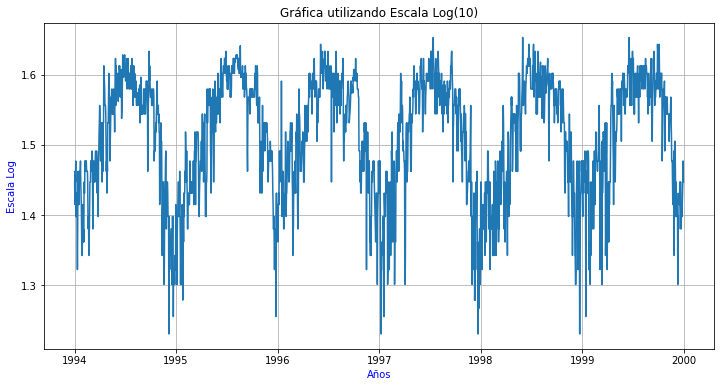

In [ ]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_TMtest)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show()

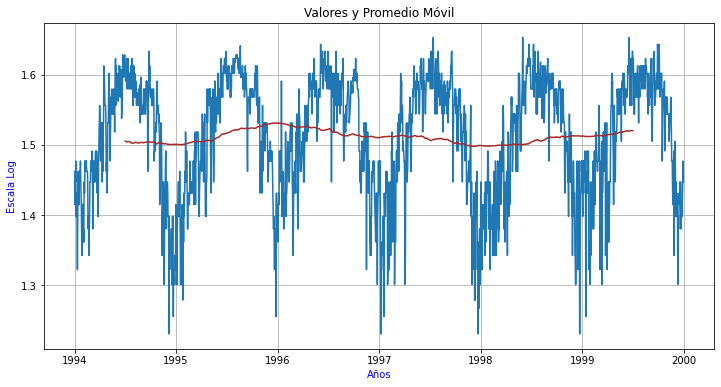

In [ ]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show()

In [ ]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1994-01-01   NaN
1994-01-02   NaN
1994-01-03   NaN
1994-01-04   NaN
1994-01-05   NaN
Name: Tmax, dtype: float64

In [ ]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1994-07-02    0.101695
1994-07-03    0.085591
1994-07-04    0.085790
1994-07-05    0.086066
1994-07-06    0.108185
Name: Tmax, dtype: float64

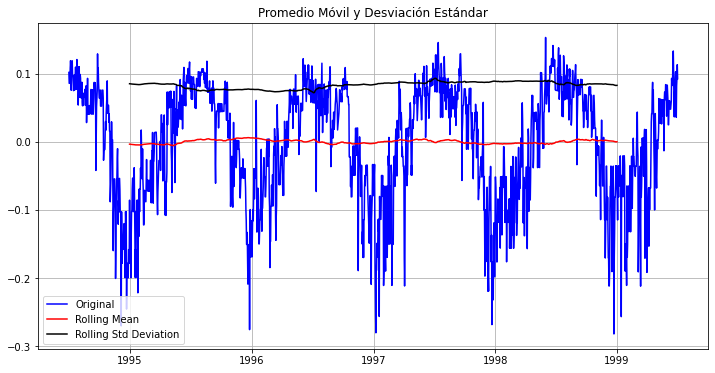

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.857341
p-value                           0.050538
#Lags Used                       18.000000
Number of Observations Used    1808.000000
Critical Value (1%)              -3.433972
Critical Value (5%)              -2.863140
Critical Value (10%)             -2.567622
dtype: float64


In [ ]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

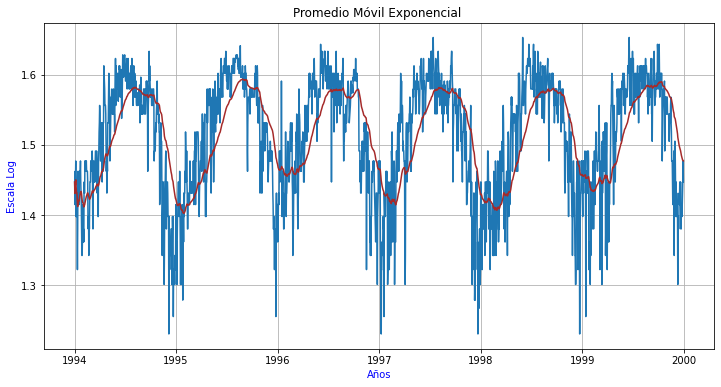

In [ ]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show()

In [ ]:
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg

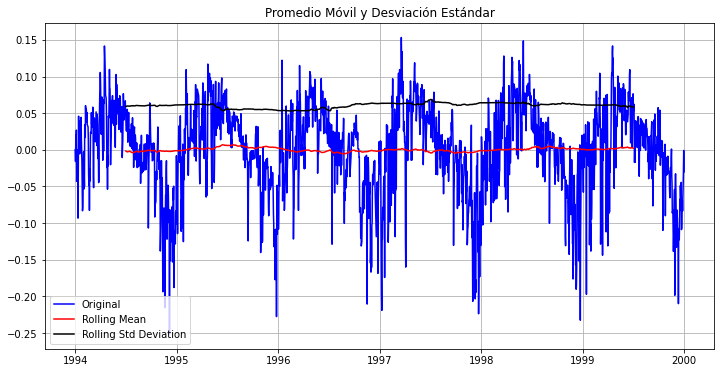

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -4.113368
p-value                           0.000920
#Lags Used                       18.000000
Number of Observations Used    2172.000000
Critical Value (1%)              -3.433364
Critical Value (5%)              -2.862872
Critical Value (10%)             -2.567479
dtype: float64


In [ ]:
test_stationarity(ts_test_log_EWM_avg_diff)

AHI LE PONES VERBO DE QUE YA SALIO


*Temperatura minima*

In [ ]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico

ts_test = ts_P ['Tmin'].copy()

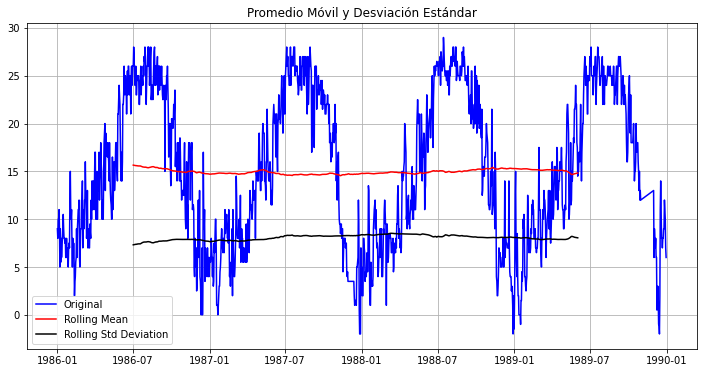

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.327436
p-value                           0.163272
#Lags Used                       10.000000
Number of Observations Used    1420.000000
Critical Value (1%)              -3.434963
Critical Value (5%)              -2.863578
Critical Value (10%)             -2.567855
dtype: float64


In [ ]:
test_stationarity(ts_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


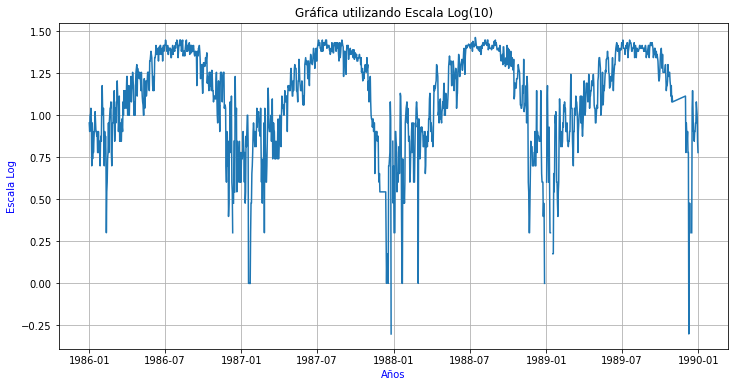

In [ ]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show()

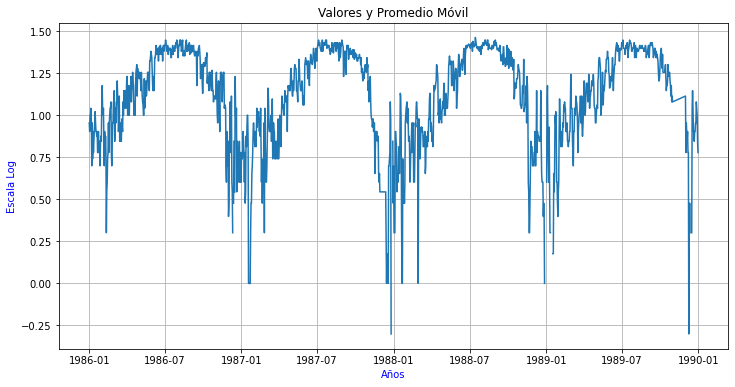

In [ ]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show()

In [ ]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1986-01-01   NaN
1986-01-02   NaN
1986-01-03   NaN
1986-01-04   NaN
1986-01-05   NaN
Name: Tmin, dtype: float64

In [ ]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1988-06-29    0.332651
Name: Tmin, dtype: float64

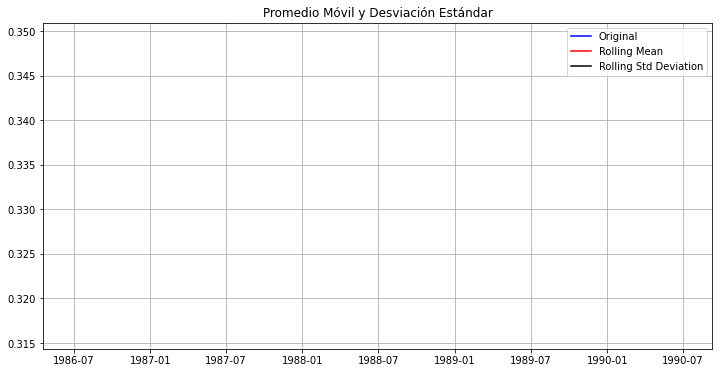

Resultados de la Prueba de Dickey-Fuller:


ValueError: ignored

In [ ]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

VERBO DE POR QUE NO SALIO

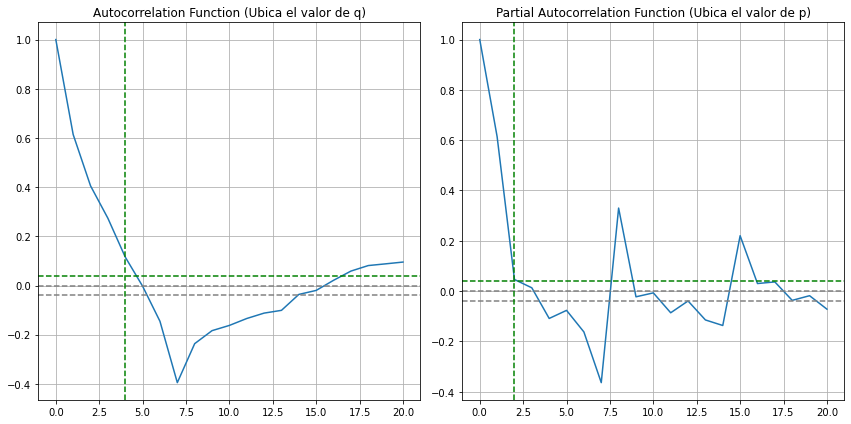

In [ ]:

# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2556
Model:                 ARIMA(2, 1, 0)   Log Likelihood                4663.026
Method:                       css-mle   S.D. of innovations              0.039
Date:                Sun, 21 Feb 2021   AIC                          -9318.052
Time:                        00:35:01   BIC                          -9294.667
Sample:                    01-02-1970   HQIC                         -9309.572
                         - 12-31-1976                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.149e-05      0.001      0.078      0.938      -0.001       0.001
ar.L1.D.Tmax    -0.2682      0.019    -13.791      0.000      -0.306      -0.230
ar.L2.D.Tmax    -0.1842      0.019     -9.47

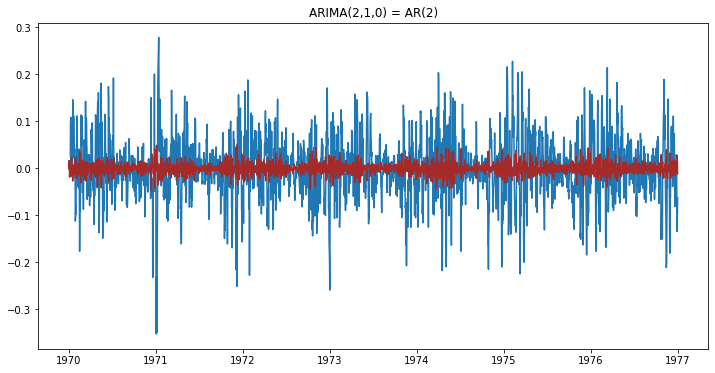

In [ ]:

# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2556
Model:                 ARIMA(0, 1, 4)   Log Likelihood                4718.193
Method:                       css-mle   S.D. of innovations              0.038
Date:                Sun, 21 Feb 2021   AIC                          -9424.386
Time:                        00:35:15   BIC                          -9389.309
Sample:                    01-02-1970   HQIC                         -9411.666
                         - 12-31-1976                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.711e-05      0.000      0.185      0.853      -0.000       0.001
ma.L1.D.Tmax    -0.3323      0.020    -16.768      0.000      -0.371      -0.293
ma.L2.D.Tmax    -0.1745      0.020     -8.54

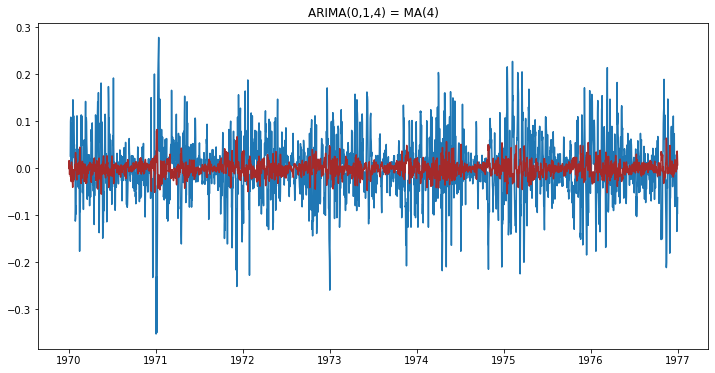

In [ ]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2556
Model:                 ARIMA(2, 1, 4)   Log Likelihood                4726.200
Method:                       css-mle   S.D. of innovations              0.038
Date:                Sun, 21 Feb 2021   AIC                          -9436.400
Time:                        00:35:37   BIC                          -9389.630
Sample:                    01-02-1970   HQIC                         -9419.439
                         - 12-31-1976                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.562e-05      0.000      0.208      0.836      -0.000       0.000
ar.L1.D.Tmax     0.5970      0.349      1.713      0.087      -0.086       1.280
ar.L2.D.Tmax    -0.0331      0.257     -0.12

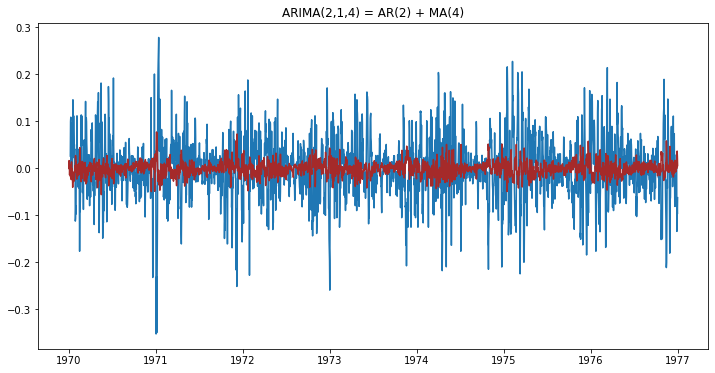

In [ ]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [ ]:

# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1970-01-02    0.000046
1970-01-03    0.016759
1970-01-04    0.009353
1970-01-05   -0.013892
1970-01-06    0.001028
                ...   
1976-12-27   -0.000400
1976-12-28    0.004317
1976-12-29    0.036976
1976-12-30    0.026444
1976-12-31    0.006133
Length: 2556, dtype: float64


In [ ]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
1970-01-01         NaN
1970-01-02    1.130379
1970-01-03    1.162887
1970-01-04    1.213473
1970-01-05    1.162200
dtype: float64
Fecha
1976-12-27    1.351783
1976-12-28    1.259589
1976-12-29    1.304147
1976-12-30    1.327474
1976-12-31    1.296168
dtype: float64


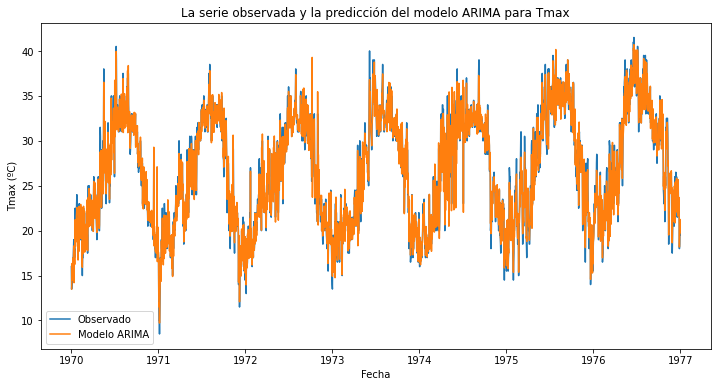

In [ ]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)


RMSE: 0.8261220542539316


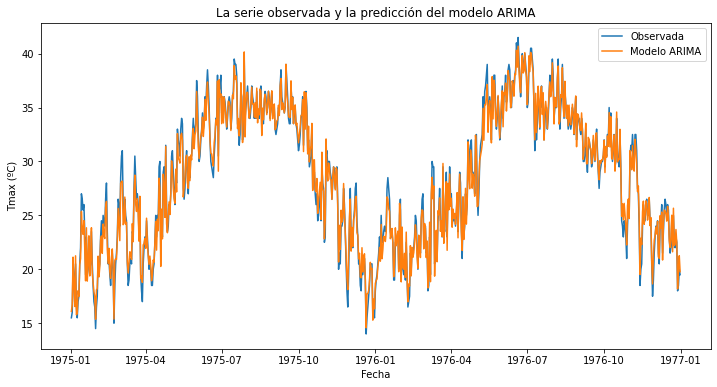

In [ ]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');